In [1]:
import pandas as pd
import numpy as np
import random
import math
import re
from scipy.special import psi #digamma function
from scipy.special import polygamma #derivative of digamma function
from scipy.special import loggamma
from IPython.display import display
import numpy.random
from nltk.tokenize import wordpunct_tokenize
import sys
import csv
import nltk
from nltk.corpus import stopwords #import stopwords
from nltk import word_tokenize, pos_tag
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
import time
import matplotlib.pyplot as plt

In [2]:
np.random.seed(1234)
meanchangethresh = 1e-3
MAXITER = 10000

In [3]:
def getVocab(file):
	#getting vocab dictionary from a csv file (nostopwords)'''
	vocab = dict()
	with open(file, 'r') as infile:
		reader = csv.reader(infile)
		for index, row in enumerate(reader):
			vocab[row[0]] = index

	return vocab

In [4]:
def getDocs(file_path):
    with open(file_path,encoding="utf-8") as f:
        docs=f.readlines()
        
    return(docs)

In [5]:
def dirichlet_expectation(a):
    if (len(a.shape)==1):
        return (psi(a)-psi(np.sum(a)))
    return (psi(a)-psi(np.sum(a,1))[:,np.newaxis])


In [6]:
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

In [7]:
def parseDocument(doc, vocab):
    #preprocessing document data
	wordslist = list()
	countslist = list()
	doc = doc.lower()
	tokens = nltk.word_tokenize(doc)#wordpunct_tokenize(doc)
	remove_chars = '[0-9’!"#$%&\'()*+,-./:;<=>?@，。?★、…【】《》？“”‘’！[\\]^_`{|}~]+'
    
	tokens=[re.sub(remove_chars,"",x.lower()) for x in tokens]
	tokens=[x for x in tokens if x!='']
    # 词形还原
	tagged_sent = pos_tag(tokens)
	wnl = WordNetLemmatizer()
	lemmas_sent = []
	for tag in tagged_sent:
		wordnet_pos = get_wordnet_pos(tag[1]) or wordnet.NOUN
		lemmas_sent.append(wnl.lemmatize(tag[0], pos=wordnet_pos)) 
	tokens=lemmas_sent

	dictionary = dict()
	for word in tokens:
		if word in vocab:
			wordtk = vocab[word]
			if wordtk not in dictionary:
				dictionary[wordtk] = 1
			else:
				dictionary[wordtk] += 1

	wordslist.append(dictionary.keys())
	countslist.append(dictionary.values())
	return (wordslist[0], countslist[0])

In [8]:
def plottrace(x, Y, K, n):
	for i in range(K):
		plt.plot(x, Y[i], label = "Topic %i" %(i+1))

	plt.xlabel("Number of Iterations")
	plt.ylabel("Probability of Each topic")
	plt.legend()
	plt.title("Trace plot for topic probabilities")
	#plt.savefig("temp/plot_%i_%i_%f.png" %(K, n, perp))

In [9]:
class SVILDA():
	def __init__(self, vocab, K, D, alpha, eta, tau, kappa, docs, iterations, minibatch,parsed = False):
		self._vocab = vocab
		self._V = len(vocab)
		self._K = K
		self._D = D
		self._alpha = alpha
		self._eta = eta
		self._tau = tau
		self._kappa = kappa
		self._lambda = 1* np.random.gamma(100., 1./100., (self._K, self._V))
		self._Elogbeta = dirichlet_expectation(self._lambda)
		self._expElogbeta = np.exp(self._Elogbeta)
		self._docs = docs
		self.ct = 1 
		self._iterations = iterations
		self._parsed = parsed
		print (self._lambda.shape)
		self._trace_lambda = {} #record lambda in every 10th iteration
		for i in range(self._K):
			self._trace_lambda[i] = [self.computeProbabilities()[i]]
		self._x = [0]
		self._minibatch = minibatch


	def updateLocal(self, doc): #word_dn is an indicator variable with dimension V?????
		print("Updating local parameters")
		(words, counts) = doc
		newdoc = []
		N_d = sum(counts) #total number of words in this doc
		phi_d = np.zeros((self._K, N_d))
		gamma_d = np.random.gamma(100., 1./100., (self._K))
		Elogtheta_d = dirichlet_expectation(gamma_d)
		expElogtheta_d = np.exp(Elogtheta_d)
		for i, item in enumerate(counts):
			for j in range(item):
				newdoc.append(list(words)[i])
		assert len(newdoc) == N_d, "error" #当len不等于N_d时，触发异常

		for i in range(self._iterations):
			for m, word in enumerate(newdoc):
				phi_d[:, m] = np.multiply(expElogtheta_d, self._expElogbeta[:, word]) + 1e-100
				phi_d[:, m] = phi_d[:, m]/np.sum(phi_d[:, m]) #normalize

			gamma_new = self._alpha + np.sum(phi_d, axis = 1)
			meanchange = np.mean(abs(gamma_d - gamma_new))
			if (meanchange < meanchangethresh):
				break

			gamma_d = gamma_new
			Elogtheta_d = dirichlet_expectation(gamma_d)
			expElogtheta_d = np.exp(Elogtheta_d)

		newdoc = np.asarray(newdoc)
		return phi_d, newdoc, gamma_d

	def updateGlobal(self, phi_docs, new_docs):
		print ('updating global parameters')
		S = len(phi_docs)
		lambda_d = np.zeros((self._K, self._V))
		lambda_s = np.zeros((self._K, self._V))

		for s in range(S):        
			for k in range(self._K):
				phi_dk = np.zeros(self._V)
				for m, word in enumerate(new_docs[s]):
                        # print word
					phi_dk[word] += phi_docs[s][k][m] 
				lambda_s[k] = self._eta + self._D * phi_dk
			lambda_d+=lambda_s
		rho = (self.ct + self._tau) **(-self._kappa)
		self._lambda = (1-rho) * self._lambda + rho * lambda_d/S
		self._Elogbeta = dirichlet_expectation(self._lambda)
		self._expElogbeta = np.exp(self._Elogbeta)

		if self.ct % 10 == 9:
			for i in range(self._K):
				self._trace_lambda[i].append(self.computeProbabilities()[i])
			self._x.append(self.ct)
            
	def runSVI(self):

		for i in range(self._iterations):			
			randints = random.sample(range(self._D),self._minibatch)
			print ("ITERATION", i, " running document number ", randints)
			if self._parsed == False:
				phi_docs={}
				new_docs={}
				gamma_docs={}
				for sample in range(self._minibatch):
					doc = parseDocument(self._docs[randints[sample]],self._vocab)
					phi_doc, newdoc, gamma_d = self.updateLocal(doc)
					phi_docs[sample]=phi_doc
					new_docs[sample]=newdoc
					gamma_docs[sample]=gamma_d
				self.updateGlobal(phi_docs, new_docs)
				self.ct += 1


	def computeProbabilities(self):

		prob_topics = np.sum(self._lambda, axis = 1)
		prob_topics = prob_topics/np.sum(prob_topics)
		return prob_topics

	def getTopics(self, docs = None):
		prob_topics = self.computeProbabilities()
		prob_words = np.sum(self._lambda, axis = 0)

		if docs == None:
			docs = self._docs
		results = np.zeros((len(docs), self._K))
		for i, doc in enumerate(docs):
			parseddoc = parseDocument(doc, self._vocab)

			for j in range(self._K):
				aux = [self._lambda[j][word]/prob_words[word] for word in parseddoc[0]]
				doc_probability = [n.log(aux[k]) * parseddoc[1][k] for k in range(len(aux))]
				results[i][j] = sum(doc_probability) + np.log(prob_topics[j])
		finalresults = np.zeros(len(docs))
		for k in range(len(docs)):
			finalresults[k] = np.argmax(results[k])
		return finalresults, prob_topics

	def calcPerplexity(self, docs = None):
		perplexity = 0.
		doclen = 0.
		if docs == None:
			docs =  self._docs
		for doc in docs:
			parseddoc = parseDocument(doc, self._vocab)
			_, newdoc, gamma_d = self.updateLocal(parseddoc)
			approx_mixture = np.dot(gamma_d, self._lambda)
			# print n.shape(approx_mixture)
			approx_mixture = approx_mixture / np.sum(approx_mixture)
			log_doc_prob = 0.
			for word in newdoc:
				log_doc_prob += np.log(approx_mixture[word])
			perplexity += log_doc_prob
			doclen += len(newdoc)
			# print perplexity, doclen
		perplexity = np.exp( - perplexity / doclen)
		print (perplexity)
		return perplexity

	def plotTopics(self):
		plottrace(self._x, self._trace_lambda, self._K, self._iterations)
			


In [10]:
def Generate_Data(num_topic,voc_size,num_doc,xi,alpha,eta):
    num_word=np.repeat(xi,num_doc)#np.random.poisson(xi,num_doc) #number of words in each document
    
    beta=np.zeros([num_topic,voc_size])
    for i in range(num_topic):
        beta[i]=np.random.dirichlet(eta)
    
    theta=np.zeros([num_doc,num_topic])
    for d in range(num_doc):
        theta[d]=np.random.dirichlet(alpha)
    
    doc={}
    for d in range(num_doc):
        W=np.zeros([voc_size,num_word[d]])
        for n in range(num_word[d]):
            z=np.random.multinomial(1,theta[d])
            topic_index=np.where(z==1)[0][0]
            w=np.random.multinomial(1,beta[topic_index,])
            W[:,n]=w
        doc[d]=W
                            
    return doc,beta,theta




np.random.seed(12345)
K=2
V=8
D=5000
xi=100
true_alpha=[0.05 for i in range(K)]
true_eta=[1.0 for i in range(V)]
docs,true_beta,true_theta=Generate_Data(K,V,D,xi,true_alpha,true_eta)

vocab={'i': 0,
 'new': 1,
 'percent': 2,
 'people': 3,
 'year': 4,
 'two': 5,
 'million': 6,
 'president': 7}
key_list=list(vocab.keys())
value_list=list(vocab.values())

new_docs=list()
for d in range(D):
    new_doc = ""
    Nd = len(docs[d][0])
    for n in range(Nd):
        pos = np.where(docs[d][:,n]==1)[0][0]
        new_doc += " "+key_list[pos]
    new_docs.append(new_doc)
    




In [11]:
random.seed(12345)
start=time.time()
k=2
alpha=0.1
iterations=100
d=len(docs)
minibatch=10
test=SVILDA(vocab = vocab, K = k, D = d, alpha = alpha, eta = 0.2, tau = 0.7, kappa = 0.7, docs = new_docs, iterations= iterations,minibatch=minibatch)
test.runSVI()
end=time.time()
print ("Running time:",str(end-start),"seconds")

(2, 8)
ITERATION 0  running document number  [3412, 83, 2446, 3018, 1586, 2213, 4636, 3573, 1324, 3056]
Updating local parameters
Updating local parameters
Updating local parameters
Updating local parameters
Updating local parameters
Updating local parameters
Updating local parameters
Updating local parameters
Updating local parameters
Updating local parameters
updating global parameters
ITERATION 1  running document number  [1017, 3546, 2138, 4604, 1428, 4531, 1530, 2907, 747, 4350]
Updating local parameters
Updating local parameters
Updating local parameters
Updating local parameters
Updating local parameters
Updating local parameters
Updating local parameters
Updating local parameters
Updating local parameters
Updating local parameters
updating global parameters
ITERATION 2  running document number  [3376, 4792, 4128, 1364, 1213, 1685, 637, 1556, 2798, 2638]
Updating local parameters
Updating local parameters
Updating local parameters
Updating local parameters
Updating local paramet

Updating local parameters
Updating local parameters
Updating local parameters
Updating local parameters
Updating local parameters
Updating local parameters
Updating local parameters
Updating local parameters
Updating local parameters
updating global parameters
ITERATION 22  running document number  [931, 4210, 258, 2793, 3212, 2616, 334, 1977, 816, 3970]
Updating local parameters
Updating local parameters
Updating local parameters
Updating local parameters
Updating local parameters
Updating local parameters
Updating local parameters
Updating local parameters
Updating local parameters
Updating local parameters
updating global parameters
ITERATION 23  running document number  [1216, 4738, 1689, 2122, 4668, 4361, 2940, 1297, 2327, 311]
Updating local parameters
Updating local parameters
Updating local parameters
Updating local parameters
Updating local parameters
Updating local parameters
Updating local parameters
Updating local parameters
Updating local parameters
Updating local paramete

Updating local parameters
updating global parameters
ITERATION 43  running document number  [1183, 3172, 1313, 2555, 2641, 4921, 2590, 3521, 321, 2901]
Updating local parameters
Updating local parameters
Updating local parameters
Updating local parameters
Updating local parameters
Updating local parameters
Updating local parameters
Updating local parameters
Updating local parameters
Updating local parameters
updating global parameters
ITERATION 44  running document number  [2009, 4919, 3750, 219, 2841, 3212, 4078, 1123, 4972, 3064]
Updating local parameters
Updating local parameters
Updating local parameters
Updating local parameters
Updating local parameters
Updating local parameters
Updating local parameters
Updating local parameters
Updating local parameters
Updating local parameters
updating global parameters
ITERATION 45  running document number  [4651, 2446, 4484, 1083, 4086, 3698, 91, 3819, 3011, 1890]
Updating local parameters
Updating local parameters
Updating local parameters

Updating local parameters
Updating local parameters
Updating local parameters
Updating local parameters
Updating local parameters
Updating local parameters
Updating local parameters
Updating local parameters
updating global parameters
ITERATION 65  running document number  [480, 2141, 999, 4367, 2446, 106, 3944, 4983, 4789, 1841]
Updating local parameters
Updating local parameters
Updating local parameters
Updating local parameters
Updating local parameters
Updating local parameters
Updating local parameters
Updating local parameters
Updating local parameters
Updating local parameters
updating global parameters
ITERATION 66  running document number  [2772, 763, 205, 106, 3374, 817, 2532, 3634, 573, 601]
Updating local parameters
Updating local parameters
Updating local parameters
Updating local parameters
Updating local parameters
Updating local parameters
Updating local parameters
Updating local parameters
Updating local parameters
Updating local parameters
updating global parameters


Updating local parameters
Updating local parameters
updating global parameters
ITERATION 86  running document number  [957, 1307, 1441, 4556, 3047, 914, 1018, 2252, 1168, 2790]
Updating local parameters
Updating local parameters
Updating local parameters
Updating local parameters
Updating local parameters
Updating local parameters
Updating local parameters
Updating local parameters
Updating local parameters
Updating local parameters
updating global parameters
ITERATION 87  running document number  [1821, 4146, 4641, 3916, 240, 2173, 2278, 3990, 2724, 2]
Updating local parameters
Updating local parameters
Updating local parameters
Updating local parameters
Updating local parameters
Updating local parameters
Updating local parameters
Updating local parameters
Updating local parameters
Updating local parameters
updating global parameters
ITERATION 88  running document number  [2687, 4144, 4596, 213, 2996, 4986, 1990, 181, 515, 4865]
Updating local parameters
Updating local parameters
Upda

In [12]:
beta=test._lambda
for i in range(k):
    beta[i]=beta[i]/np.sum(beta[i])
pd.DataFrame(np.around(beta,3))

,0,1,2,3,4,5,6,7
0,0.278,0.037,0.02,0.019,0.09,0.093,0.353,0.110
1,0.160,0.122,0.16,0.384,0.00,0.013,0.040,0.121


In [13]:
pd.DataFrame(np.around(true_beta,3))

,0,1,2,3,4,5,6,7
0,0.276,0.040,0.021,0.024,0.087,0.094,0.347,0.110
1,0.160,0.123,0.160,0.377,0.001,0.013,0.041,0.124


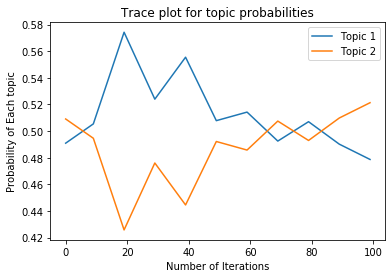

In [14]:
test.plotTopics()